<a href="https://colab.research.google.com/github/fiuzaaa/Analise--mercado/blob/master/Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ta

In [2]:
# Clone the entire repo.
import os
from getpass import getpass
user = 'fiuzaaa'
password = 'mathema10!'
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/fiuzaaa/Analise--mercado.git
%cd cloned-repo
!ls

fatal: destination path 'Analise--mercado' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'cloned-repo'
/content
Analise--mercado  sample_data


In [3]:
import pandas as pd
import numpy as np
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

from ta.volatility import BollingerBands
from ta import add_all_ta_features
from ta.utils import dropna
from scipy.stats import linregress

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [4]:
def describe_dataset(X, y, k):
# get dataset rows: instances , columns: features
  rows, columns = X.shape
# get proportion from target
  (unique, counts) = np.unique(y, return_counts=True) 
# calculate proportion
  print(counts)
  prop_neg = int(counts[0]/rows*100)
  prop_zer = int(counts[1]/rows*100)
  prop_pos = int(counts[2]/rows*100)
  print("k = {}, Dataset: {} negativas, {} zeros, {} positivas,  ({}% x {}% x {}%)".format(k, counts[0], counts[1], counts[1], prop_neg, prop_zer, prop_pos))
  print("")


In [5]:
def t_concat(data, n):
    # data = Dataframe
    # n = Periodos
  col = data.name
  columns = map(str, range(n-1,-1,-1))
  columns = [col + sub for sub in columns]
  data1 = pd.DataFrame(columns=columns)
  
  for x in range(1, n + 1):
      data1[columns[x-1]] = data.shift(x)
  return data1


In [6]:
def get_ic(data, alpha):

    # Calcula as ic das medidas
    accuracy_ic_inf, accuracy_ic_sup = sms.DescrStatsW(data['accuracy']).tconfint_mean(alpha)
    precision_ic_inf, precision_ic_sup = sms.DescrStatsW(data['precision']).tconfint_mean(alpha)
    recall_ic_inf, recall_ic_sup = sms.DescrStatsW(data['recall']).tconfint_mean(alpha)
    fscore_ic_inf, fscore_ic_sup = sms.DescrStatsW(data['fscore']).tconfint_mean(alpha)
    
    ic = [accuracy_ic_inf, accuracy_ic_sup, precision_ic_inf, precision_ic_sup, recall_ic_inf, recall_ic_sup, fscore_ic_inf, fscore_ic_sup]

    return ic

In [7]:
def get_classes_from_index(y, skf):
    _, y_idx, y_inv = np.unique(y, return_index=True, return_inverse=True)
    y_counts = np.bincount(y_inv)
    _, class_perm = np.unique(y_idx, return_inverse=True)
    y_encoded = class_perm[y_inv]
    y_order = np.sort(y_encoded)
    n_classes = len(y_idx)
    allocation = np.asarray(
            [np.bincount(y_order[i::skf.n_splits], minlength=n_classes)
             for i in range(skf.n_splits)])

    for idx, f in enumerate(allocation):
        count_neg = int(f[0])
        count_zer = int(f[2])
        count_pos = int(f[1])
        total = count_neg+count_zer+count_pos
        prop_temp_neg = int(count_neg/total*100)
        prop_temp_zer = int(count_zer/total*100)
        prop_temp_pos = int(count_pos/total*100)
        print("Fold {}: Zer: {}, Pos: {}, Neg: {}, Total: {}, Proporção: {}% x {}% x {}%".format(idx, count_zer ,count_pos, count_neg, total, prop_temp_zer, prop_temp_pos, prop_temp_neg))
    print("")

In [8]:
data = pd.read_csv('Analise--mercado/Data/WINQ20_5min.csv', sep=';', decimal=",",encoding='latin-1' )
# Clean NaN values
data = data.stack().str.replace('.','').unstack()
data = data.stack().str.replace(',','.').unstack()
data = dropna(data)

data.loc[:,'Abertura':'Quantidade'] = data.loc[:,'Abertura':'Quantidade'].astype(float)

# Clean NaN values
data = dropna(data)
# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=data["Fechamento"], n=20, ndev=2)

# Add Bollinger Bands features
data['bb_bbm'] = data.Fechamento-indicator_bb.bollinger_mavg()
data['bb_bbh'] = data.Fechamento-indicator_bb.bollinger_hband()
data['bb_bbl'] = data.Fechamento-indicator_bb.bollinger_lband()

#data['bb_bbm'] = (data['bb_bbm']-data['bb_bbm'].min())/(data['bb_bbm'].max()-data['bb_bbm'].min())
#data['bb_bbh'] = (data['bb_bbh']-data['bb_bbh'].min())/(data['bb_bbh'].max()-data['bb_bbh'].min())
#data['bb_bbl'] = (data['bb_bbl']-data['bb_bbl'].min())/(data['bb_bbl'].max()-data['bb_bbl'].min())

# Add Bollinger Band high indicator
data['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
data['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

# Add Width Size Bollinger Bands
data['bb_bbw'] = indicator_bb.bollinger_wband()

# Add Percentage Bollinger Bands
data['bb_bbp'] = indicator_bb.bollinger_pband()

data.head(70)


,Ativo,Data,Hora,Abertura,Máximo,Mínimo,Fechamento,Volume,Quantidade,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp
0,WINQ20,31/07/2020,17:50:00,103165,103175,102955,103100,9.49274e+08,46046,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,WINQ20,31/07/2020,17:45:00,103075,103240,103060,103165,9.14276e+08,44319,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,WINQ20,31/07/2020,17:40:00,103090,103120,103035,103080,6.80706e+08,33019,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,WINQ20,31/07/2020,17:35:00,103140,103205,103045,103090,1.11667e+09,54143,NaN,NaN,NaN,0.0,0.0,NaN,NaN
4,WINQ20,31/07/2020,17:30:00,103055,103200,103000,103140,1.40863e+09,68317,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,WINQ20,31/07/2020,12:25:00,103965,104070,103945,104005,1.4088e+09,67721,539.75,-67.9051,1147.41,0.0,0.0,1.174607,0.944125
66,WINQ20,31/07/2020,12:20:00,103965,104050,103905,103965,1.75456e+09,84375,456.5,-164.009,1077.01,0.0,0.0,1.198952,0.867843
67,WINQ20,31/07/2020,12:15:00,104040,104115,103885,103965,3.15898e+09,151839,411.5,-204.35,1027.35,0.0,0.0,1.189433,0.834091
68,WINQ20,31/07/2020,12:10:00,103930,104065,103905,104040,2.05334e+09,98727,438.5,-171.87,1048.87,0.0,0.0,1.178303,0.859209


In [9]:
time = 500

bb_bbm = go.Scatter(
    x=data.index,
    y=data['bb_bbm'][0:time],
    name = 'bb_bbm',
    line = dict(color = '#00FF00'),
    opacity = 0.8)

bb_bbh = go.Scatter(
    x=data.index,
    y=data['bb_bbh'][0:time],
    name = 'bb_bbh',
    line = dict(color = '#00FF00'),
    opacity = 0.8)

bb_bbl = go.Scatter(
    x=data.index,
    y=data['bb_bbl'][0:time],
    name = 'bb_bbl',
    line = dict(color = '#00FF00'),
    opacity = 0.8)

#Gerando o gráfico de Candlestick
trace = go.Candlestick(x=data.index,
                      open=data['Abertura'][0:time],
                      high=data['Máximo'][0:time],
                      low=data['Mínimo'][0:time],
                      close=data['Fechamento'][0:time])
close = go.Scatter(
    x=data.index,
    y=data.Fechamento[0:time],
    name = 'WINQ20',
    line = dict(color = '#330000'),
    opacity = 0.8)

df = [ bb_bbm, bb_bbh, bb_bbl]
py.iplot(df, filename='simple_candlestick')

In [10]:
df = [ close]
py.iplot(df, filename='simple_candlestick')

In [11]:
data['alvo1']= data.Fechamento.diff(periods=1).shift(-1)
data['alvo2']= data.Fechamento.diff(periods=2).shift(-2)
data['alvo3']= data.Fechamento.diff(periods=3).shift(-3)
data['target'] = 0
data.target[(data.alvo1+data.alvo2+data.alvo3)/3 > 0] = 1
data.target[(data.alvo1+data.alvo2+data.alvo3)/3 < 0] = -1

data[['Fechamento','alvo1','alvo2','alvo3','target']]#.mean(axis=1)

,Fechamento,alvo1,alvo2,alvo3,target
0,103100,65,-20,-10,1
1,103165,-85,-75,-25,-1
2,103080,10,60,-20,1
3,103090,50,-30,130,1
4,103140,-80,80,85,1
...,...,...,...,...,...
4587,78000,195,-325,205,1
4588,78195,-520,10,1205,1
4589,77675,530,1725,NaN,0
4590,78205,1195,NaN,NaN,0


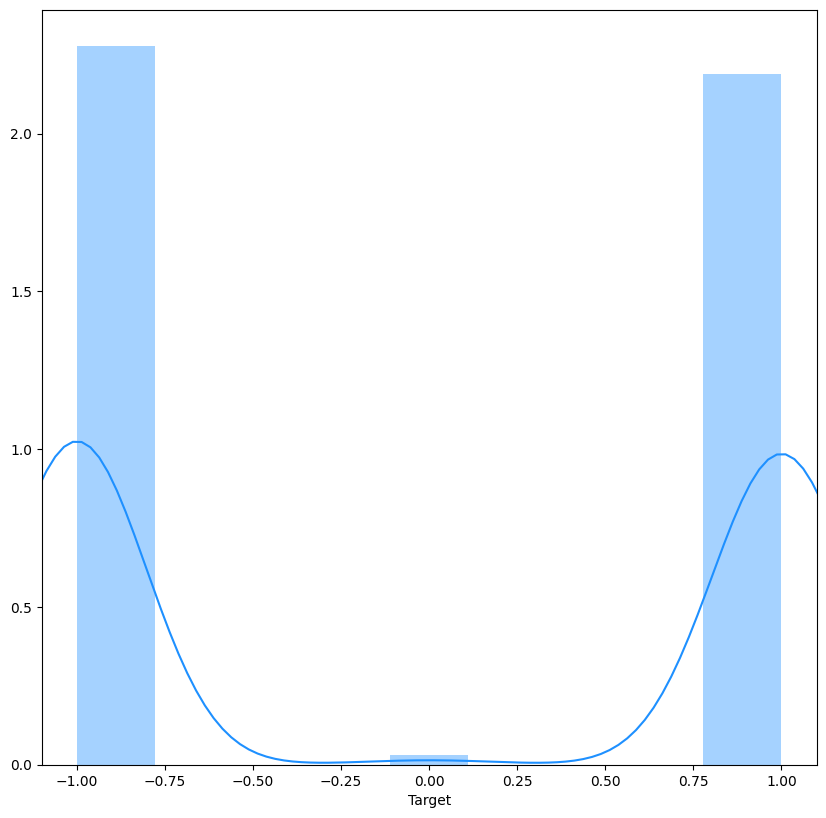

In [12]:
# plot
fig, axes = plt.subplots(1, figsize=(10, 10), sharey=True, dpi=100)
sns.distplot(data.target, color="dodgerblue", axlabel='Target')
plt.xlim(-1.10,1.10);

In [13]:
delta = 10
data1 = pd.concat([t_concat(data['Fechamento'],delta),
                  t_concat(data['bb_bbm'],delta),
                  t_concat(data['bb_bbh'],delta),
                  t_concat(data['bb_bbl'],delta),
                  t_concat(data['bb_bbhi'],delta),
                  t_concat(data['bb_bbli'],delta),
                  t_concat(data['bb_bbw'],delta),
                  t_concat(data['bb_bbp'],delta),data.target],axis=1)

In [14]:
data1.to_csv("Analise--mercado/Data/Data1.csv", index=False)
print(data1.shape)
data1

(4592, 81)


,Fechamento9,Fechamento8,Fechamento7,Fechamento6,Fechamento5,Fechamento4,Fechamento3,Fechamento2,Fechamento1,Fechamento0,bb_bbm9,bb_bbm8,bb_bbm7,bb_bbm6,bb_bbm5,bb_bbm4,bb_bbm3,bb_bbm2,bb_bbm1,bb_bbm0,bb_bbh9,bb_bbh8,bb_bbh7,bb_bbh6,bb_bbh5,bb_bbh4,bb_bbh3,bb_bbh2,bb_bbh1,bb_bbh0,bb_bbl9,bb_bbl8,bb_bbl7,bb_bbl6,bb_bbl5,bb_bbl4,bb_bbl3,bb_bbl2,bb_bbl1,bb_bbl0,...,bb_bbhi8,bb_bbhi7,bb_bbhi6,bb_bbhi5,bb_bbhi4,bb_bbhi3,bb_bbhi2,bb_bbhi1,bb_bbhi0,bb_bbli9,bb_bbli8,bb_bbli7,bb_bbli6,bb_bbli5,bb_bbli4,bb_bbli3,bb_bbli2,bb_bbli1,bb_bbli0,bb_bbw9,bb_bbw8,bb_bbw7,bb_bbw6,bb_bbw5,bb_bbw4,bb_bbw3,bb_bbw2,bb_bbw1,bb_bbw0,bb_bbp9,bb_bbp8,bb_bbp7,bb_bbp6,bb_bbp5,bb_bbp4,bb_bbp3,bb_bbp2,bb_bbp1,bb_bbp0,target
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,103100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,103165,103100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,103080,103165,103100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,103090,103080,103165,103100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4587,78490,78500,79000,80275,79000,79925,81600,81100,80600,81340,-1775.25,-1865.75,-1452.75,-228.25,-1410.5,-485.5,1235.75,889.5,500,1390.25,-3964.76,-3899.04,-3299.63,-1965.45,-3370.35,-2445.35,-809.543,-1222.33,-1645.11,-1000.6,414.26,167.541,394.127,1508.95,549.352,1474.35,3281.04,3001.33,2645.11,3781.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.455686,5.060094,4.591209,4.315850,4.874617,4.874617,5.090056,5.265715,5.356070,5.980893,0.0946011,0.0411995,0.106701,0.434305,0.140151,0.376139,0.802096,0.7106,0.616544,0.790743,1
4588,78000,78490,78500,79000,80275,79000,79925,81600,81100,80600,-2140.25,-1775.25,-1865.75,-1452.75,-228.25,-1410.5,-485.5,1235.75,889.5,500,-4537.48,-3964.76,-3899.04,-3299.63,-1965.45,-3370.35,-2445.35,-809.543,-1222.33,-1645.11,256.979,414.26,167.541,394.127,1508.95,549.352,1474.35,3281.04,3001.33,2645.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.982583,5.455686,5.060094,4.591209,4.315850,4.874617,4.874617,5.090056,5.265715,5.356070,0.0535991,0.0946011,0.0411995,0.106701,0.434305,0.140151,0.376139,0.802096,0.7106,0.616544,1
4589,78195,78000,78490,78500,79000,80275,79000,79925,81600,81100,-1827,-2140.25,-1775.25,-1865.75,-1452.75,-228.25,-1410.5,-485.5,1235.75,889.5,-4359.26,-4537.48,-3964.76,-38

In [15]:
def Classifier_grid(X, y, k, parameters_in , Classifier, dataSet):
     
    """
    Parameters
    ----------    
              X: array-like, shape (n_samples, n_features) -- Training data, where n_samples is the number of samples and n_features is the number of features.
              y: array-like, of length n_samples  -- The target variable for supervised learning problems.
              k: int -- Determines the number of folds.
        dataSet: method selection (string)
  parameters_in: all parameters (tuple)

    """
    ### Estratifica o dataset em k folds
    skf = StratifiedKFold(n_splits=k)
    describe_dataset(X, y, k)
    get_classes_from_index(y, skf) 

    ### ParameterGrid
    list_parameters = ParameterGrid(parameters_in)
       
    #################################################################################################################
    # 1. Classifier 
    #################################################################################################################
    result = []
    result_ic = []
    result_k = []
    result_best = []

    total_p = len(list_parameters)
    print("---")
    print('Quantidade de parametros:', total_p)
    p=1
    for P in list_parameters:
        print('Parametro:',p,'/',total_p)
        print(P)

        ### resultado do fold-k
        clf = Classifier(**P)

        fold_k = 1
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            ### Train the model
            clf.fit(X_train, y_train)
    
            ### Test the model
            y_predicted = clf.predict(X_test)
            
            ### calculate metrics
            report_dict = metrics.classification_report(y_test, y_predicted, output_dict=True)
            report_str = metrics.classification_report(y_test, y_predicted)        
            print(report_str)
            
            all_metrics = precision_recall_fscore_support(y_true=y_test, y_pred=y_predicted, average='weighted')
            accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_predicted)
            
            precision = all_metrics[0]
            recall = all_metrics[1]
            fscore = all_metrics[2]
            #print('Accuracy: ',accuracy)
            #print('precision: ',precision)                
            ### Armazena o resultado do fold k
            r = [Classifier.__name__, dataSet, fold_k, accuracy ,  precision,  recall , fscore] + list(P.values())
            result_k.append(r)
            #print(result_k)
            fold_k = fold_k + 1
            
    
        columns_r = [Classifier.__name__,'Dataset', 'fold', 'accuracy','precision','recall','fscore'] + list(P.keys())
        p=p+1
        result_k = pd.DataFrame(result_k, columns=columns_r)

        ### calcula a média das métricas dos k-folds      
        accuracy_avg = result_k['accuracy'].mean()
        precision_avg = result_k['precision'].mean()
        recall_avg = result_k['recall'].mean()
        fscore_avg = result_k['fscore'].mean()
        
        ### Calcula o índice de confiança dos k-folds
        alpha = 0.05
        ic_c = [dataSet] + list(get_ic(result_k, alpha))
        
        ### Armazena a média dos resultados dos k-folds e o índice de confiança
        result.append([Classifier.__name__,dataSet, accuracy_avg, precision_avg, recall_avg, fscore_avg] + list(P.values())) 
        result_ic.append(list(ic_c) + list(P.values()))
        result_k = []

    
    ### Exibe a media dos resultados de cada valor
    columns_avg = ['Classifier', 'dataSet','accuracy_avg','precision_avg','recall_avg','fscore_avg'] + list(P.keys())
    result = pd.DataFrame(result, columns=columns_avg)

      
    columns_ic = ['dataSet','accuracy_ic_inf','accuracy_ic_sup','precision_ic_inf','precision_ic_sup','recall_ic_inf', 'recall_ic_sup','fscore_ic_inf', 'fscore_ic_sup'] + list(P.keys())
    result_ic = pd.DataFrame(result_ic, columns=columns_ic)
    #print("Média dos resultados")
    #print(result)
    #print(result_ic)
    #print("")
        
    #################################################################################################################
    ### ARMAZENA OS MELHORES RESULTADOS 
    #################################################################################################################
    
    ### Armazena apenas as métricas da melhor acurácia média do MODELO e o seu indice de confiança
  
    result_best = pd.DataFrame(result.iloc[[result['accuracy_avg'].argmax()]])
    print(result_best)
   
    ic_best = pd.DataFrame(result_ic.iloc[[result['accuracy_avg'].argmax()]])
    print(ic_best)
    
    return result_best, ic_best 

In [16]:
df = data1
df = df.dropna()
X = df.drop('target', axis=1).to_numpy() # DATASET
y = df.target.to_numpy() # target
k_folds = 10


In [17]:
parameters_in = {'var_smoothing': [0.001, 0.10, 0.25, 0.50, 0.75, 1,2,3,10,20,25,30,50]}
#result_NB_all, ic_NB_all = Classifier_grid(X, y, k_folds, parameters_in, GaussianNB, dataSet='All Feasture')
print("Melhor resultado:")
#result_NB_all

Melhor resultado:


In [18]:
list_kernel = ['linear','rbf']

for kernel in list_kernel:
  print(kernel)
  parameters_in = {'C': [0.001, 0.10],
                 'kernel': [kernel],
                 'degree': [1],
                 'gamma' : [0.001]}
  #exec("SVM_{i}_all, SVM_{i}_ic_all = Classifier_grid(X, y, k_folds, parameters_in, svm.SVC, dataSet='All Features')".format(i=kernel))

linear
rbf


In [19]:
parameters_in = {'n_estimators': [100,500,1000], #default=(100)
                 'max_features': ["sqrt", "log2"], #sqrt(n_features)
                 'criterion' : ['gini', 'entropy'] #default=”gini”
                 }
#RF_all,RF_all_ic = Classifier_grid(X, y, k_folds, parameters_in,RandomForestClassifier, dataSet='All Features')
#RF_all

In [ ]:
parameters_in = {'activation': ['identity','logistic','tanh','relu'], # {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
                 'hidden_layer_sizes': [(200,200,200,200)], #default=(100,)
                 'learning_rate_init': [0.001, 0.01], #default=0.001
                 'max_iter':[5000]
                 }
RN_chi,RN_chi_ic = Classifier_grid(X, y, k_folds, parameters_in,MLPClassifier, dataSet='CHI')

[2310   32 2221]
k = 10, Dataset: 2310 negativas, 32 zeros, 32 positivas,  (50% x 0% x 48%)

Fold 0: Zer: 3, Pos: 223, Neg: 231, Total: 457, Proporção: 0% x 48% x 50%
Fold 1: Zer: 4, Pos: 222, Neg: 231, Total: 457, Proporção: 0% x 48% x 50%
Fold 2: Zer: 4, Pos: 222, Neg: 231, Total: 457, Proporção: 0% x 48% x 50%
Fold 3: Zer: 3, Pos: 222, Neg: 231, Total: 456, Proporção: 0% x 48% x 50%
Fold 4: Zer: 3, Pos: 222, Neg: 231, Total: 456, Proporção: 0% x 48% x 50%
Fold 5: Zer: 3, Pos: 222, Neg: 231, Total: 456, Proporção: 0% x 48% x 50%
Fold 6: Zer: 3, Pos: 222, Neg: 231, Total: 456, Proporção: 0% x 48% x 50%
Fold 7: Zer: 3, Pos: 222, Neg: 231, Total: 456, Proporção: 0% x 48% x 50%
Fold 8: Zer: 3, Pos: 222, Neg: 231, Total: 456, Proporção: 0% x 48% x 50%
Fold 9: Zer: 3, Pos: 222, Neg: 231, Total: 456, Proporção: 0% x 48% x 50%

---
Quantidade de parametros: 8
Parametro: 1 / 8
{'activation': 'identity', 'hidden_layer_sizes': (200, 200, 200, 200), 'learning_rate_init': 0.001, 'max_iter': 5000}

In [ ]:
RN_chi
